# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(28480, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(7738, 512)

In [6]:
yb.shape, yq.shape

((28480,), (7738,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 675)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

29.25656

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.21163781

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
28480


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[659 659 659 659 659]
 [959 959 959 959 959]
 [868 868 868 868 868]
 [631 631 631 631 631]
 [100 100 100 100 100]]
[[659]
 [959]
 [868]
 [631]
 [100]]
[[0.99999976 0.84152985 0.8371571  0.8310425  0.8309983 ]
 [1.0000001  0.9594742  0.9523885  0.9343024  0.93015176]
 [1.0000002  0.9126117  0.90547216 0.8906253  0.88462025]
 [1.0000002  0.85370374 0.83744705 0.8275811  0.8254597 ]
 [1.         0.8681463  0.8610753  0.84559155 0.844572  ]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((28480,), (28480,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([659, 959, 868, 631, 100, 359, 755, 407, 362, 921]),
 array([659, 959, 868, 631, 100, 359, 755, 407, 362, 921]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([ 334, 1050,  324,  348,  896,  616,  168,  713,  713,  941]),
 array([ 334, 1050,  324,  348,  896,  616,  168,  713,  713,  941]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

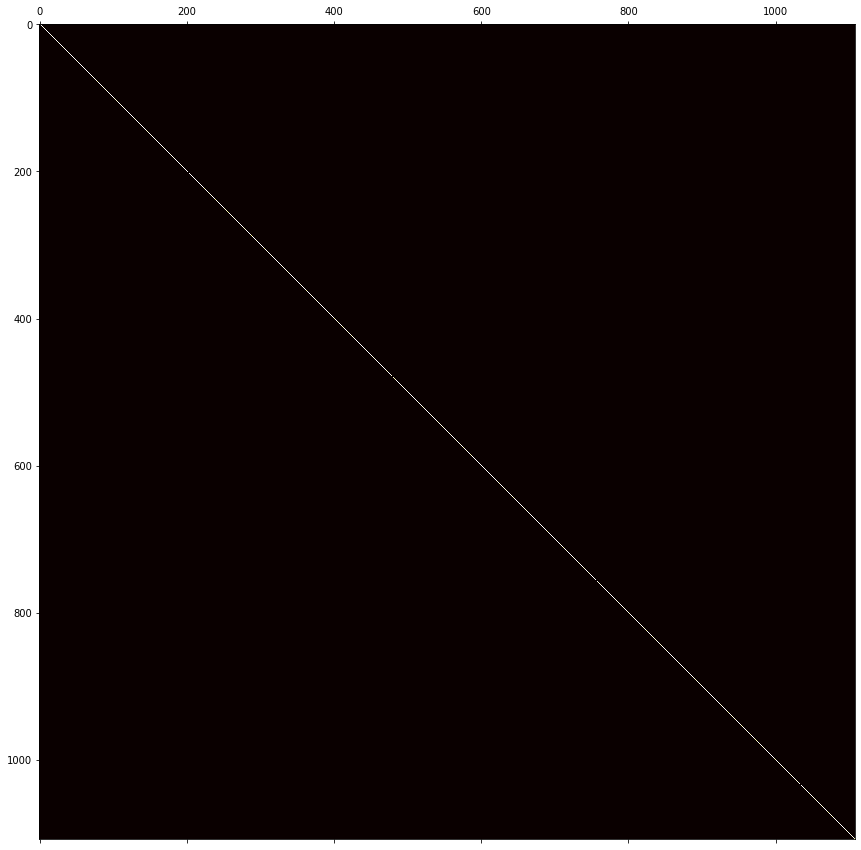

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [23]:
xq.max()

24.841463

In [24]:
faiss.normalize_L2(xq)

In [25]:
xq.max()

0.2088738

In [26]:
D_valid, I_valid = index.search(xq, k) # actual search

In [27]:
xq.shape, yq.shape

((7738, 512), (7738,))

In [28]:
I_valid.shape, D_valid.shape

((7738, 5), (7738, 5))

In [29]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[773 646 677 773 773]
 [932 932 932 932 932]
 [838 838 838 838 838]
 [380 380 380 380 380]
 [883 798 798 798 798]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.65027106 0.5987239  0.5778115  0.56525326 0.54938143]
 [0.6280104  0.62323767 0.54965305 0.54497147 0.5298943 ]
 [0.5483084  0.50360334 0.48499376 0.4387055  0.4283173 ]
 [0.6332028  0.60646814 0.5980013  0.5748882  0.5511546 ]
 [0.53968716 0.5330294  0.48933667 0.48615512 0.47806662]]


In [30]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[143 143 143 143 143]
 [565 565 565 831 565]
 [172 172 172 172 172]
 [203 646 646 646 203]
 [942 942 942 372 942]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.60633224 0.5253755  0.5043524  0.49437425 0.48315537]
 [0.5318464  0.51022816 0.49453437 0.4770643  0.46947372]
 [0.51926666 0.45491242 0.44613534 0.41061735 0.4095977 ]
 [0.4795711  0.4318719  0.41783756 0.4030749  0.40250248]
 [0.50481397 0.48255605 0.4683519  0.46495467 0.4646972 ]]


In [31]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [32]:
I_valid[:,0]

array([773, 932, 838, ..., 172, 203, 942])

In [33]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [34]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

1649

In [35]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.213104161281985

In [36]:
valid_correct = np.equal(I_valid[:,0], yq)

In [37]:
valid_correct

array([False, False, False, ..., False, False, False])

In [38]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [39]:
cm = confusion_matrix(I_valid[:,0], yq)

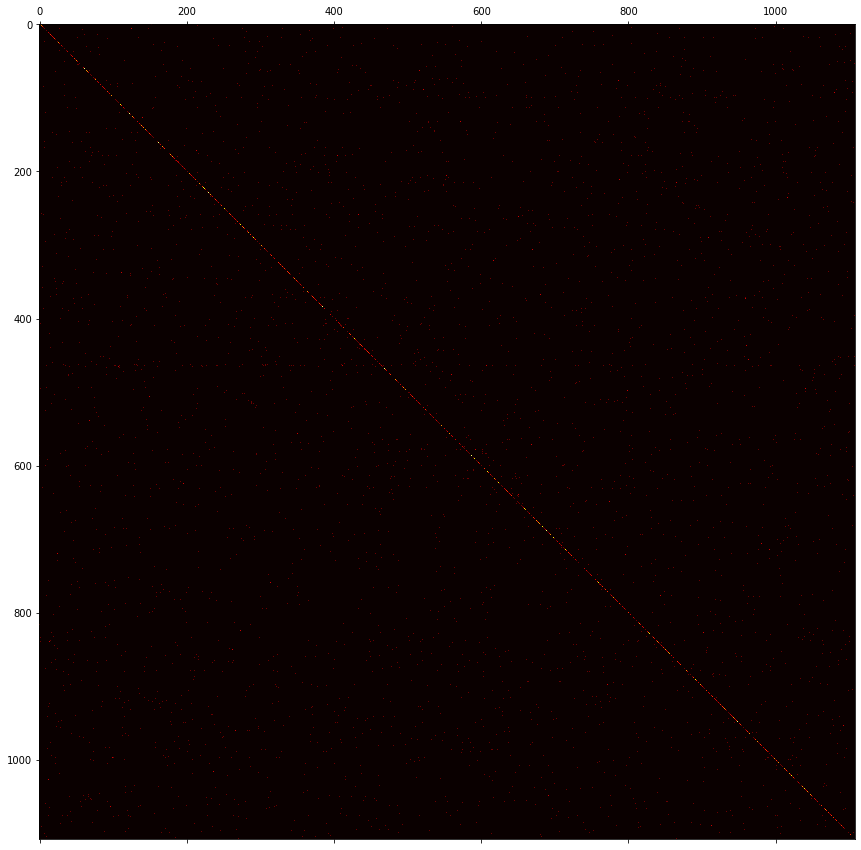

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Test

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [41]:
xq_test = np.load('pred/feats_test.npy')

In [42]:
xq_test.max()

29.677961

In [43]:
faiss.normalize_L2(xq_test)

In [44]:
xq_test.max()

0.21299735

In [45]:
D_test, I_test = index.search(xq_test, k) # actual search

In [46]:
xq_test.shape, I_test.shape, D_test.shape

((19897, 512), (19897, 5), (19897, 5))

In [47]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 52  34  52  34  52]
 [ 69  69  69  69  69]
 [889 889 889 889 889]
 [148 148 692 148 148]
 [903 903 903 903 903]]
[[0.5819852  0.52940124 0.5086951  0.50214314 0.48427263]
 [0.5430572  0.50153494 0.50138295 0.4921887  0.47738594]
 [0.60398483 0.53907835 0.49434692 0.4916092  0.48859945]
 [0.61278474 0.6074268  0.60608584 0.59626466 0.5949392 ]
 [0.58636856 0.581688   0.5796226  0.5659604  0.5587972 ]]


In [48]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[609 609 609 609 609]
 [316 316 316 316 316]
 [429 429 429 429 429]
 [271 271 271 271 271]
 [557 557 557 557 557]]
[[0.56991595 0.56752384 0.55519325 0.540334   0.5353565 ]
 [0.81115836 0.79597056 0.7805606  0.7190074  0.7118658 ]
 [0.63554895 0.5710726  0.5692278  0.5401236  0.51056135]
 [0.5818975  0.5575959  0.55067396 0.54471415 0.5447123 ]
 [0.74964166 0.72111326 0.7170322  0.6918341  0.6907745 ]]


In [49]:
I_test[2]

array([889, 889, 889, 889, 889])

In [50]:
np.unique(I_test[2], return_counts=True)

(array([889]), array([5]))

In [51]:
preds_test = I_test[:,0]

In [52]:
np.save('pred/preds_test.npy', preds_test)